# E-Commerce data with Neural network

In this note, I am going to use neural network to analyze a e-commerce data. The data is from Udemy: Deep Learning with Python lecture. The label will have multiple class. The model will have 1 hidden layer with 5 hidden units and use `logistic function` for activation. The output layer will be activated by `softmax`. 

## Process the Data

Import required library and the data. Print out first few rows to confirm the data structure. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Plotting library
from sklearn.utils import shuffle
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the result is reproducable
np.random.seed(seed=1)

# check the data first
df = pd.read_csv('../data/ecommerce_data.csv')
df.head()

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day,user_action
0,1,0,0.657510,0,3,0
1,1,1,0.568571,0,2,1
2,1,0,0.042246,1,1,0
3,1,1,1.659793,1,1,2
4,0,1,2.014745,1,1,2


In [2]:
# 4 unique values for time_of_day
df.time_of_day.unique()

array([3, 2, 1, 0])

The 2nd and 3rd column is numeric and need to be normalized. 1st, 4th and 5th colums are categorized variable. 5th column `time_of_day` will need to be transformed to 4 one-hot encoding variables. Last column `user_action` is the label. Code below will tranform the raw data into the format for training.

In [3]:
def get_data():
    df = pd.read_csv('../data/ecommerce_data.csv')
    data = df.as_matrix()
    
    X = data[:, :-1] # last column is label
    Y = data[:, -1]
    
    # Normalization for 2nd and 3rd columns
    X[:, 1] = (X[:, 1] - X[: ,1].mean())/X[:, 1].std()
    X[:, 2] = (X[:, 2] - X[: ,2].mean())/X[:, 2].std()
    
    # handle time_of_day
    R, C = X.shape
    # we will have 4 more columns for each value in time_of_day (4 unique values)
    X2 = np.zeros((R, C+3)) # initialized as zero
    Z = np.zeros((R, 4))
    Z[np.arange(R), X[:, C-1].astype(np.int32)] = 1
    # copy data from X except time_of_day
    X2[:, 0:(C-1)] = X[:, 0:(C-1)] 
    # add 4 dummy variables for time_of_day
    X2[:, (C-1):(C+3)] = Z 
    return X2, Y

# Produce multi-class indicator for Y
def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

## Forward Step, Cost Function
`Forward step` will involve softmax and logistic function. For the mathmatical details, see [Itetsu Blog: Neural-Network Cost-Function](https://weichetaru.github.io/machine-learning/2016/12/11/deep_learning-neural-network-gradient-decent-part2#Model-and-Cost-Function).  
We can at first produce functions for producing prediction as below.

In [4]:
def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

def forward(X, W1, b1, W2, b2):
    Z = np.tanh(X.dot(W1) + b1)
    return softmax(Z.dot(W2) + b2), Z # also return cost of hidden layer to calculate derivatives

def predict(P_Y_given_X):
    return np.argmax(P_Y_given_X, axis=1)

def classification_rate(Y, P):
    return np.mean(Y == P)

def cross_entropy(T, pY):
    return -np.mean(T*np.log(pY))

Below will train a neural network model with 1 hidden layer with `logistic function` and output layer activating with `softmax function`.

In [5]:
# create train data
X, Y = get_data()
X, Y = shuffle(X, Y)
Y = Y.astype(np.int32)
M = 5 # n of hidden units
D = X.shape[1] # n of inputs
K = len(set(Y)) # n of class/ output nodes

# training data
Xtrain = X[:-100]
Ytrain = Y[:-100]
Ytrain_ind = y2indicator(Ytrain, K)
# test/validation data
Xtest = X[-100:]
Ytest = Y[-100:]
Ytest_ind = y2indicator(Ytest, K)

# initialize weight
W1 = np.random.randn(D, M)
b1 = np.zeros(M)
W2 = np.random.randn(M, K)
b2 = np.zeros(K)

## Gradient Decent with Backpropgation

For the mathmatical details, see [Itetsu Blog: Neural-Network Backward-propagation](https://weichetaru.github.io/machine-learning/2016/12/11/deep_learning-neural-network-gradient-decent-part2#Backward-propagation).  

0 0.441957162691 0.450534803992
1000 0.0281723683437 0.0590422462772
2000 0.0196657062323 0.0488279355369
3000 0.0160427678162 0.0471629629124
4000 0.0140355995025 0.0477433060571
5000 0.0127004005938 0.0494705150612
6000 0.0117289453824 0.0520005517575
7000 0.0110124850203 0.054495311859
8000 0.0104710171871 0.0567952669422
9000 0.0100499271421 0.0589211074589
Final train classification_rate: 0.9875
Final test classification_rate: 0.93


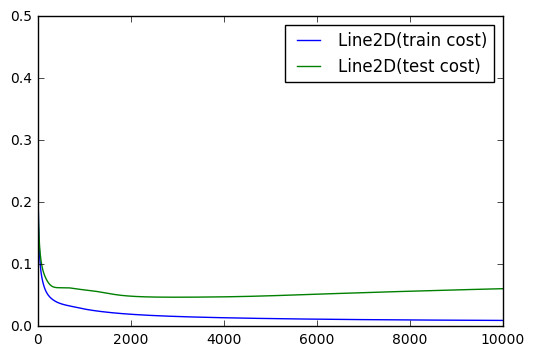

In [6]:
# start training
train_costs = []
test_costs = []
learning_rate = 0.001

for i in range(10000):
    pYtrain, Ztrain = forward(Xtrain, W1, b1, W2, b2)
    pYtest, Ztest = forward(Xtest, W1, b1, W2, b2)
    
    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)
    train_costs.append(ctrain)
    test_costs.append(ctest)
    
    W2 -= learning_rate*Ztrain.T.dot(pYtrain - Ytrain_ind)
    b2 -= learning_rate*(pYtrain - Ytrain_ind).sum(axis=0)
    dZ = (pYtrain - Ytrain_ind).dot(W2.T) * (1- Ztrain*Ztrain)
    W1 -= learning_rate*Xtrain.T.dot(dZ)
    b1 -= learning_rate*dZ.sum(axis=0)
    if i % 1000 == 0:
        print(i, ctrain, ctest)

print("Final train classification_rate:", classification_rate(Ytrain, predict(pYtrain)))
print("Final test classification_rate:", classification_rate(Ytest, predict(pYtest)))

legend1, = plt.plot(train_costs, label='train cost')
legend2, = plt.plot(test_costs, label='test cost')
plt.legend([legend1, legend2])
plt.show()